<a href="https://colab.research.google.com/github/alheir/nnii-cv/blob/main/tp02_datacentric_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 - Datacentric CV

25.87 - Redes Neuronales II

> Computer Vision


Alumno: HEIR, Alejandro Nahuel

Legajo: 62496

e-mail: aheir@itba.edu.ar

Utilizando la siguiente librería [ImageNet Datasets Downloader](https://github.com/mf1024/ImageNet-Datasets-Downloader)

1. Bajar imágenes de 20 clases.
2. Instanciar una ResNet-18
    * Loss = "categorical_crossentropy"
    * Optimizer = "adam"
    * Early Stopping
    * ReduceLearningRateOnPlateau
    * ModelCheckPoint
3. Entrenar el modelo optimizando los HP anteriores.
4. A partir de ahora, sin modificar los parámetros anteriores, reentrenar el modelo utilizando distintas técnicas de aumentación (desde el mismo punto, preentrenado con imagenet).
    * Utilizar siempre el mismo conjunto de datos para validación (estos no se aumentan)
5. Para la mejor performance que hayan obtenido, informar el pipeline de aumentación que utilizaron.

*Bonus: hacer búsqueda de hiperparámetros automática con MLFlow y Tensorboard.*

# Paquetes y módulos

In [ ]:
!pip install datasets --quiet
!pip install pyarrow==15.0.2 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests

from datasets import load_dataset, DatasetDict
import os
import random

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageNet Datasets Downloader

## Descarga del dataset

In [ ]:
!git clone https://github.com/mf1024/ImageNet-Datasets-Downloader.git

Cloning into 'ImageNet-Datasets-Downloader'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 130 (delta 5), reused 6 (delta 2), pack-reused 113 (from 1)
Receiving objects: 100% (130/130), 1.58 MiB | 1.42 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
!rm -rf data/imagenet_images/

In [ ]:
n_classes = 20
n_images_per_class = 50

In [ ]:
!mkdir -p data
!python ImageNet-Datasets-Downloader/downloader.py \
    -data_root data \
    -number_of_classes {n_classes} \
    -images_per_class {n_images_per_class} \
    # -multiprocessing_workers 24

Picked the following clases:
['queen', 'spotted hyena', 'hop', 'sibling', 'bracer', 'guacamole', 'goose grass', 'neon lamp', 'paper fastener', 'flea beetle', 'boat hook', 'termite', 'fishtail palm', 'military leader', 'registrar', 'legume', 'truss bridge', 'swing', 'doggie bag', 'niece']
Scraping images for class "queen"
Multiprocessing workers: 8
Scraping images for class "spotted hyena"
Multiprocessing workers: 8
Scraping images for class "hop"
Multiprocessing workers: 8
Scraping images for class "sibling"
Multiprocessing workers: 8

Scraping stats:
STATS For class is_flickr:
 tried 242.0 urls with 171.0 successes
70.66115702479338% success rate for is_flickr urls 
0.16417926654481052 seconds spent per is_flickr succesful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 242.0 urls with 171.0 successes
70.66115702479338% success rate for all urls 
0.16417980333517868 seconds spent per all succesful image download
Scraping images

In [ ]:
images_root_path = "data/imagenet_images/"

In [ ]:
!ls {images_root_path}

'boat hook'	 'flea beetle'	 legume		   'paper fastener'  'spotted hyena'
 bracer		 'goose grass'	'military leader'   queen	      swing
'doggie bag'	  guacamole	'neon lamp'	    registrar	      termite
'fishtail palm'   hop		 niece		    sibling	     'truss bridge'


In [ ]:
folder_list = os.listdir(images_root_path)
folder_list.sort()
print(folder_list)

['boat hook', 'bracer', 'doggie bag', 'fishtail palm', 'flea beetle', 'goose grass', 'guacamole', 'hop', 'legume', 'military leader', 'neon lamp', 'niece', 'paper fastener', 'queen', 'registrar', 'sibling', 'spotted hyena', 'swing', 'termite', 'truss bridge']


## Carga del dataset

In [ ]:
dataset = load_dataset("data/imagenet_images/", split="train")
print(dataset)
print(dataset[0])

Resolving data files:   0%|          | 0/1087 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 1087
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7CC8210272B0>, 'label': 0}


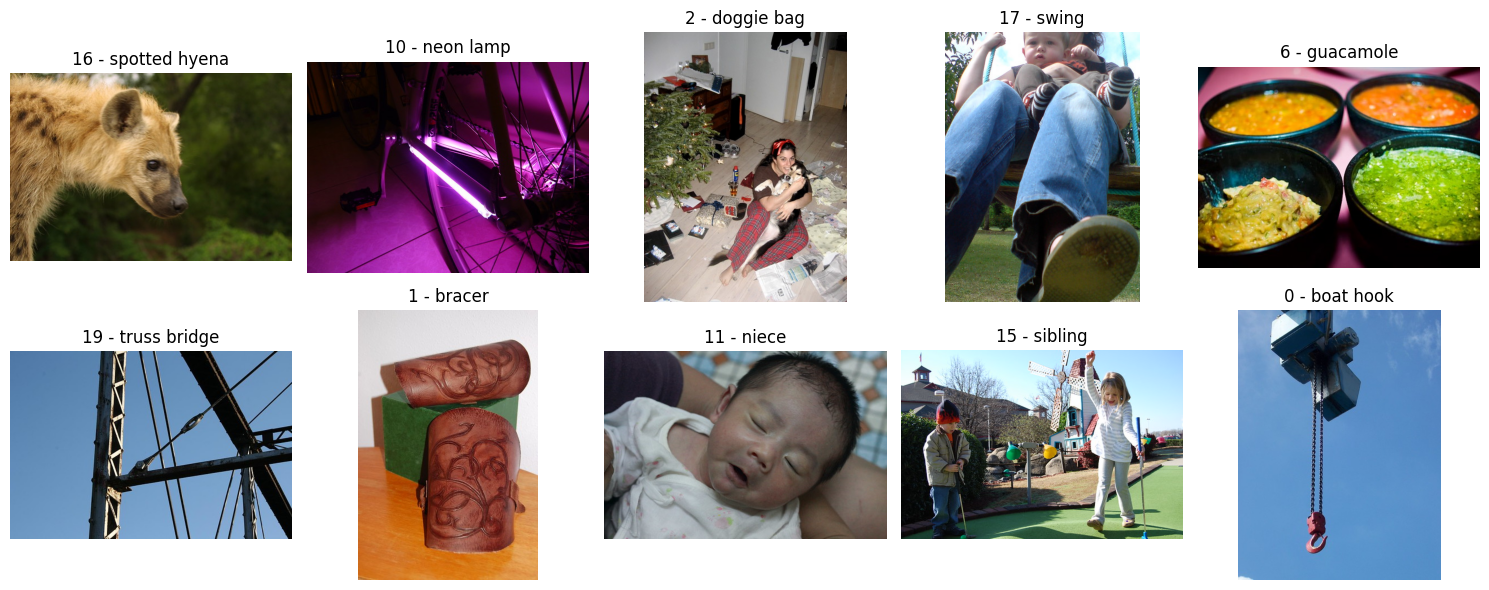

In [ ]:
def display_random_images(dataset, num_images=10):
  fig, axes = plt.subplots(2, 5, figsize=(15, 6))
  axes = axes.flatten()
  random_indices = random.sample(range(len(dataset)), num_images)

  for i, index in enumerate(random_indices):
    example = dataset[index]
    image = example['image']
    id = example['label']
    axes[i].imshow(image)
    axes[i].set_title(f"{id} - {folder_list[id]}")
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

display_random_images(dataset)

## Split del dataset (train test val)

[splitting-dataset-into-train-test-and-validation-using-huggingface-datasets-fun](https://stackoverflow.com/questions/76001128/splitting-dataset-into-train-test-and-validation-using-huggingface-datasets-fun)

In [ ]:
shuffled_dataset = dataset.shuffle(seed=42)

train_testvalid = shuffled_dataset.train_test_split(test_size=0.2)
print(train_testvalid)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 869
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 218
    })
})


In [ ]:
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
print(test_valid)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 109
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 109
    })
})


In [ ]:
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 869
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 109
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 109
    })
})


In [ ]:
del test_valid
del train_testvalid
del dataset

# ResNet50

## Instancia

In [ ]:
# ResNet50 sin preentrenar
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Agregar capas fully connected
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,706,388 (98.06 MB)

 Trainable params: 25,653,268 (97.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 1er entrenamiento

In [ ]:
def preprocess_img(img):
    img = img.resize((224, 224))  # Redimensionar la imagen a 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocesar la imagen según VGG16
    return img_array

In [ ]:
def preprocess_function(examples):
  images = [preprocess_img(image.convert("RGB"))[0] for image in examples["image"]]
  labels = [tf.keras.utils.to_categorical(label, num_classes=n_classes) for label in examples["label"]]
  return {"pixel_values": images, "labels": labels}

prepared_ds = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/869 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

In [ ]:
train_dataset = prepared_ds["train"].to_tf_dataset(
    columns=["pixel_values"], label_cols=["labels"], shuffle=True, batch_size=32
)
validation_dataset = prepared_ds["valid"].to_tf_dataset(
    columns=["pixel_values"], label_cols=["labels"], shuffle=False, batch_size=32
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 463s 13s/step - accuracy: 0.0588 - loss: 5.6529 - val_accuracy: 0.0642 - val_loss: 17.2266 - learning_rate: 0.0010
Epoch 2/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 11:11 25s/step - accuracy: 0.0312 - loss: 3.4253

KeyboardInterrupt: 